In [1]:
from entropypilot.config import config
import os
import nest_asyncio
from entropypilot.utils import visualize_palette

nest_asyncio.apply()

os.environ["OPENAI_API_KEY"] = config.openai_api_key


In [2]:
neg_prompt = "Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must NOT contain any shade of red or orange."
neg_prompt

'Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must NOT contain any shade of red or orange.'

In [3]:
aff_prompt = "Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must ONLY contain shades of cool blues, aquas, and teals."
aff_prompt

'Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must ONLY contain shades of cool blues, aquas, and teals.'

In [4]:
from openai import OpenAI
from entropypilot.utils.models import Colors

client = OpenAI()


def get_colors_from_llm(prompt: str, model: str = "gpt-4o-mini") -> Colors:
    """
    Calls the LLM and demands a raw JSON list of hex codes.
    """
    try:
        completion = client.chat.completions.parse(
            model=model,
            response_format=Colors,
            messages=[
                {
                    "role": "system",
                    "content": "You are a color palette generator. Output only raw JSON lists of 6 hex codes under the key 'palette'.",
                },
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.parsed or Colors(palette=["#cccccc"] * 6)
    except Exception as e:
        print(f"Error generating colors: {e}")
        # Return a fallback gray palette if LLM fails entirely
        return Colors(palette=["#cccccc"] * 6)


Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must NOT contain any shade of red or orange.


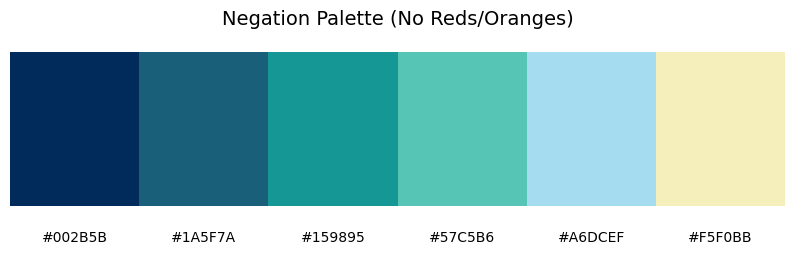

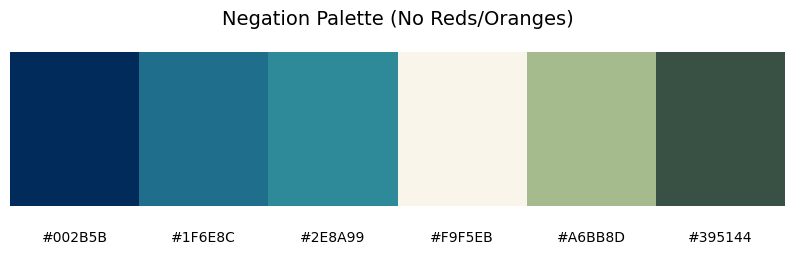

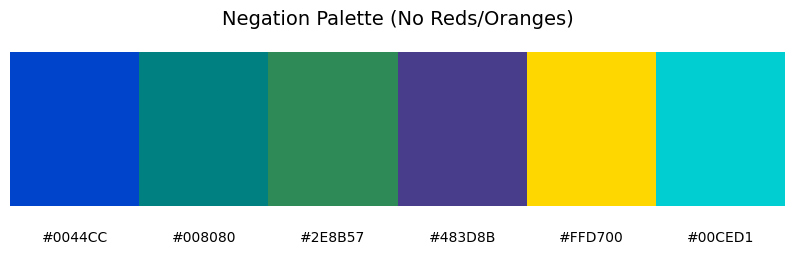

In [5]:
print(neg_prompt)

for i in range(3):
    neg_colors = get_colors_from_llm(neg_prompt, model="gpt-5.1")
    if neg_colors:
        visualize_palette(neg_colors.palette, "Negation Palette (No Reds/Oranges)")

The above is high entropy. The model had to consider the entire universe of colors and try to apply a 'not red' filter. That filter is leaky.


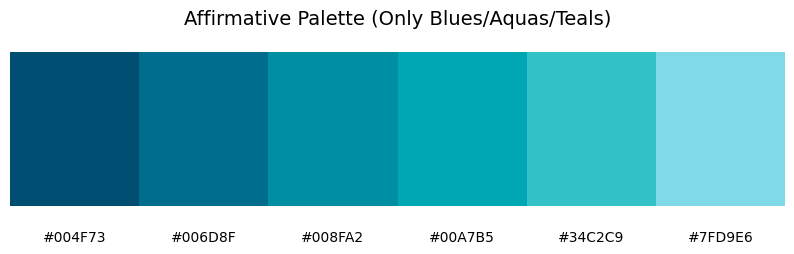

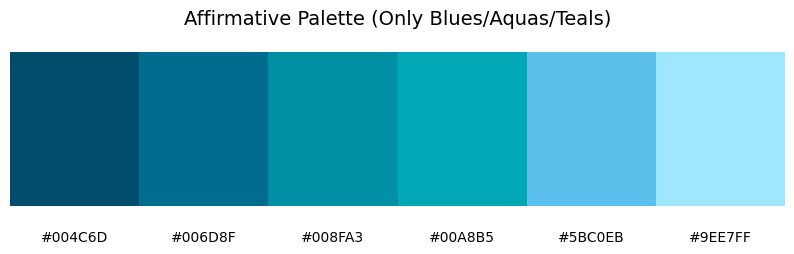

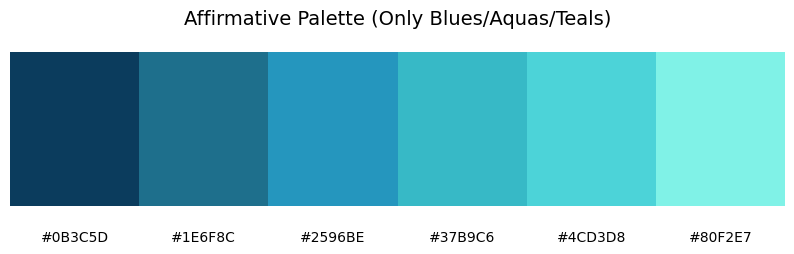

In [6]:
for i in range(3):
    aff_prompt_colors = get_colors_from_llm(aff_prompt, model="gpt-5.1")

    if aff_prompt_colors:
        visualize_palette(
            aff_prompt_colors.palette, "Affirmative Palette (Only Blues/Aquas/Teals)"
        )

In [7]:
num_runs = 100

# Statistics tracking
stats = {
    "negative": {
        "total_runs": 0,
        "runs_with_violations": 0,
        "total_colors": 0,
        "violation_colors": 0,
        "violation_examples": [],  # Store some examples of violations
        "all_palettes": [],  # Store all generated palettes
        "all_violations": [],  # Store violation status per color
    },
    "affirmative": {
        "total_runs": 0,
        "runs_with_violations": 0,
        "total_colors": 0,
        "violation_colors": 0,
        "violation_examples": [],
        "all_palettes": [],
        "all_violations": [],
    },
}

Run 1/100...
Run 10/100...
Run 20/100...
Run 30/100...
Run 40/100...
Run 50/100...
Run 60/100...
Run 70/100...
Run 80/100...
Run 90/100...
Run 100/100...


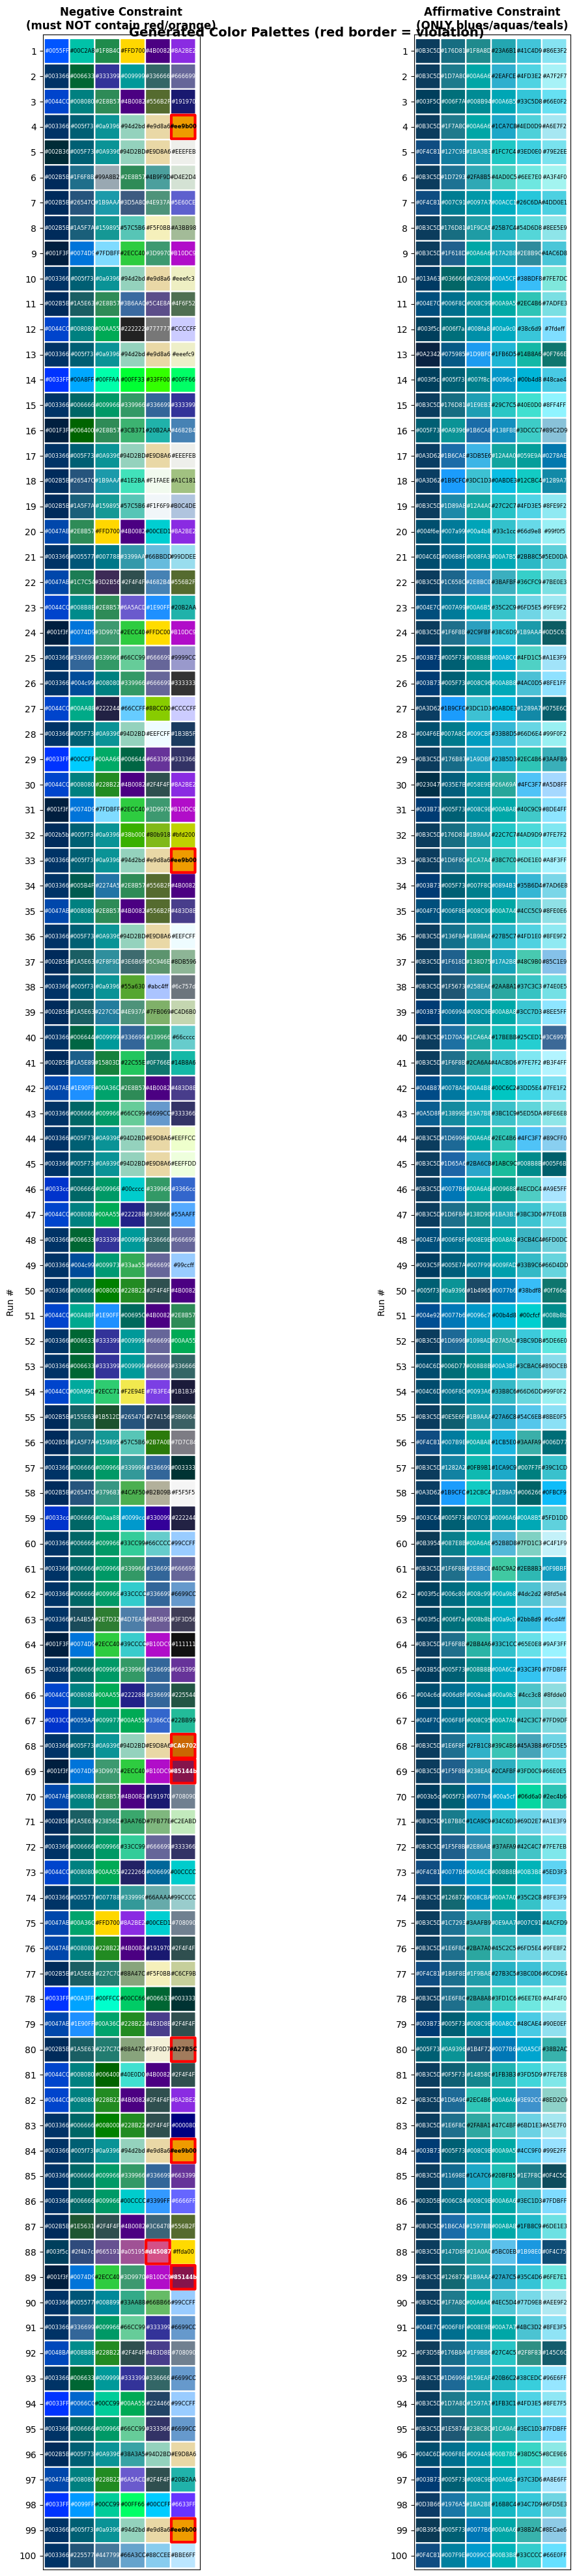

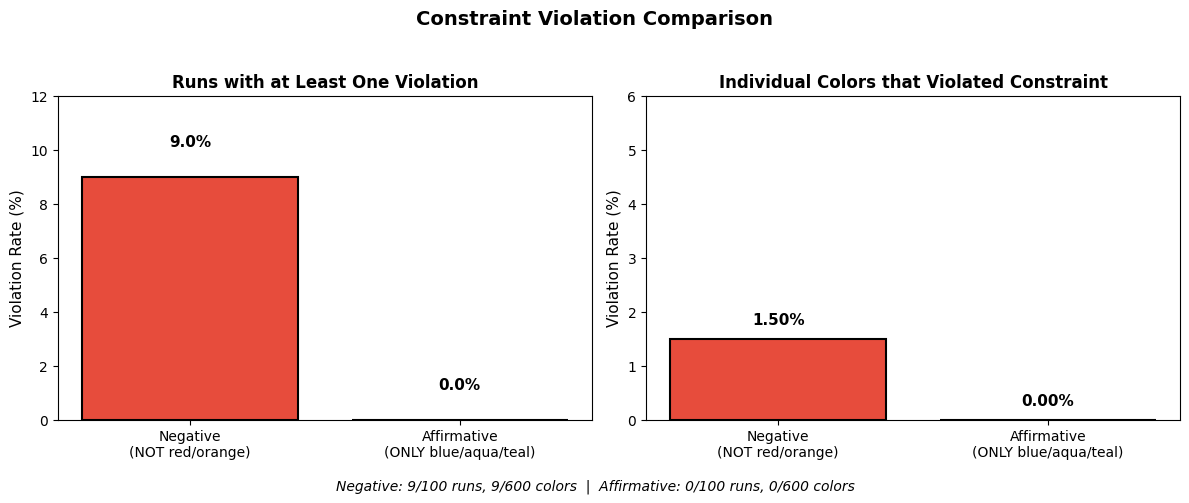

In [8]:
from entropypilot.simulation import (
    is_red_or_orange,
    is_cool_blue_aqua_teal,
    plot_color_palettes,
    plot_results_graph,
)


for i in range(num_runs):
    if (i + 1) % 10 == 0 or i == 0:
        print(f"Run {i + 1}/{num_runs}...")

    # Test negative constraint
    neg_colors = get_colors_from_llm(neg_prompt, model="gpt-5.1")
    if neg_colors:
        stats["negative"]["total_runs"] += 1
        stats["negative"]["total_colors"] += len(neg_colors.palette)
        stats["negative"]["all_palettes"].append(neg_colors.palette)
        violation_mask = [is_red_or_orange(c) for c in neg_colors.palette]
        stats["negative"]["all_violations"].append(violation_mask)
        violations = [c for c, v in zip(neg_colors.palette, violation_mask) if v]
        if violations:
            stats["negative"]["runs_with_violations"] += 1
            stats["negative"]["violation_colors"] += len(violations)
            if len(stats["negative"]["violation_examples"]) < 10:
                stats["negative"]["violation_examples"].append(
                    {
                        "run": i + 1,
                        "palette": neg_colors.palette,
                        "violations": violations,
                    }
                )

    # Test affirmative constraint
    aff_colors = get_colors_from_llm(
        aff_prompt,
        model="gpt-5.1",
    )
    if aff_colors:
        stats["affirmative"]["total_runs"] += 1
        stats["affirmative"]["total_colors"] += len(aff_colors.palette)
        stats["affirmative"]["all_palettes"].append(aff_colors.palette)
        violation_mask = [not is_cool_blue_aqua_teal(c) for c in aff_colors.palette]
        stats["affirmative"]["all_violations"].append(violation_mask)
        violations = [c for c, v in zip(aff_colors.palette, violation_mask) if v]
        if violations:
            stats["affirmative"]["runs_with_violations"] += 1
            stats["affirmative"]["violation_colors"] += len(violations)
            if len(stats["affirmative"]["violation_examples"]) < 10:
                stats["affirmative"]["violation_examples"].append(
                    {
                        "run": i + 1,
                        "palette": aff_colors.palette,
                        "violations": violations,
                    }
                )


plot_color_palettes(stats, max_palettes=100)
plot_results_graph(stats)

## Entropy Isn’t Just Linguistic — It’s Structural

The same entropy dynamics apply beyond natural language. Ambiguity introduced by data representation or interface design expands the model’s search space in exactly the same way as ambiguous prompts.

To illustrate this, consider a simple example: representing a player’s height.

### Height Encoding: Ambiguity by Design


In [9]:
{"height": 510}

{'height': 510}

- Is this 5′10″?
- Is it 510 cm?
- Is it 510 inches?
- Is it $feet × 100 + inches$?
- Is it an internal encoding convention?

The model must infer intent. Probability mass spreads.


In [10]:
{"height": {"feet": 5, "inches": 10}}

{'height': {'feet': 5, 'inches': 10}}

- One interpretation
- No decoding step
- No convention guessing
- No inverse mapping required

Key line to land the point:

This isn’t about making the model smarter — it’s about removing degrees of freedom.


Every ambiguous decision point expands the universe of possible outcomes; reliability is the discipline of collapsing that universe before the model ever has to choose.


Reliability emerges when we design systems that minimize the number of valid worlds the model can inhabit.
